# E-Commerce Shipping Data: Optuna 기반 배송 지연 예측

**프로젝트 개요:**
본 프로젝트는 전자상거래 배송 데이터를 분석하여 **제품의 정시 배송 여부(Reached.on.Time_Y.N)**를 예측하는 머신러닝 모델을 구축합니다.
EDA를 통해 배송 지연의 핵심 원인을 파악하고, 다양한 모델을 **Optuna**로 최적화하여 최고 성능 모델을 선정합니다.

**Kaggle:** [E-Commerce Shipping Dataset](https://www.kaggle.com/datasets/prachi13/customer-analytics/data)

## 목차
1. [데이터셋 소개](#1-데이터셋-소개)
2. [라이브러리 임포트 & 데이터 로딩](#2-라이브러리-임포트)
3. [탐색적 데이터 분석 (EDA)](#3-탐색적-데이터-분석)
4. [시각화](#4-시각화)
5. [전처리](#5-전처리)
6. [특성 공학](#6-특성-공학)
7. [모델링](#7-모델링)
8. [하이퍼파라미터 튜닝 (Optuna)](#8-하이퍼파라미터-튜닝)
9. [모델 비교 평가](#9-모델-비교-평가)

## 1. 데이터셋 소개 <a id='1-데이터셋-소개'></a>

### 배경
국제 전자상거래 회사의 배송 데이터로, 고객 정보와 제품/배송 특성을 기반으로 **정시 배송 여부**를 예측하는 이진 분류 문제입니다.

### 데이터 규모
- **총 데이터 수:** 10,999건
- **변수 수:** 12개 (타겟 1개 포함)
- **결측치:** 없음

### 데이터 명세 (Data Dictionary)

| 구분 | 컬럼명 | 설명 | 데이터 타입 | 비고 |
|:---:|:---|:---|:---:|:---|
| **Target** | `Reached.on.Time_Y.N` | 정시 배송 여부 (0: 정시, 1: 지연) | int64 | **타겟 변수** |
| **Index** | `ID` | 고유 식별자 | int64 | 분석 시 제거 |
| **Categorical** | `Warehouse_block` | 창고 구역 (A, B, C, D, F) | object | 5개 범주 |
| | `Mode_of_Shipment` | 배송 수단 (Ship, Flight, Road) | object | 3개 범주 |
| | `Product_importance` | 제품 중요도 (low, medium, high) | object | 3개 범주 |
| | `Gender` | 고객 성별 (F, M) | object | 2개 범주 |
| **Numerical** | `Customer_care_calls` | 고객센터 문의 횟수 | int64 | 2~7 범위 |
| | `Customer_rating` | 고객 평점 (1~5) | int64 | 순서형 |
| | `Cost_of_the_Product` | 제품 가격 (USD) | int64 | 96~310 범위 |
| | `Prior_purchases` | 이전 구매 횟수 | int64 | 2~10 범위 |
| | `Discount_offered` | 할인율 (%) | int64 | **핵심 변수** |
| | `Weight_in_gms` | 제품 무게 (g) | int64 | **핵심 변수** |

### 데이터 특징
- **클래스 분포:** 지연(1)이 약 60%, 정시 배송(0)이 약 40%로 약간의 불균형 존재
- **핵심 인사이트:** 할인율(`Discount_offered`)과 무게(`Weight_in_gms`)가 배송 지연과 강한 상관관계를 보임
- **데이터 품질:** 결측치 및 중복 데이터 없음 (클린 데이터)

## 2. 라이브러리 임포트 & 데이터 로딩 <a id='2-라이브러리-임포트'></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Optuna
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ===== GPU 사용 여부 설정 =====
USE_GPU = False  # False로 변경 시 CPU 모드로 전환

# ===== CPU 코어 제한 (전체의 2/3) =====
N_JOBS = max(1, int(os.cpu_count() * 2 / 3))

if USE_GPU:
    print('GPU 모드 활성화')
    print(f'  - XGBoost  : tree_method="hist", device="cuda"')
    print(f'  - LightGBM : device="gpu"')
    print(f'  - CatBoost : task_type="GPU"')
else:
    print('CPU 모드로 실행합니다.')

print(f'\nCPU 코어 사용: {N_JOBS} / {os.cpu_count()} (2/3 제한)')
print('All libraries loaded successfully.')

CPU 모드로 실행합니다.

CPU 코어 사용: 9 / 14 (2/3 제한)
All libraries loaded successfully.


In [2]:
# 데이터 로딩 (data2 폴더)
HOME = os.getcwd()
dataPath = os.path.join(HOME, 'data', 'Train.csv')

df = pd.read_csv(dataPath)
print(f'\u25b6 데이터 로드 성공: {df.shape}')
display(df.head())

▶ 데이터 로드 성공: (10999, 12)


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


## 3. 탐색적 데이터 분석 (EDA) <a id='3-탐색적-데이터-분석'></a>

데이터의 품질을 점검하고 기초 통계량을 확인하여 전처리 방향성을 설정합니다.

In [3]:
# 데이터 기본 정보
print(f"{'='*20} [Data Info] {'='*20}")
df.info()

# 결측치 및 중복값 확인
print(f"\n{'='*20} [Quality Check] {'='*20}")
null_cnt = df.isnull().sum().sum()
dup_cnt = df.duplicated().sum()
print(f'\u25b6 총 결측치 수 : {null_cnt}개')
print(f'\u25b6 중복 데이터 수: {dup_cnt}개')

==================== [Data Info] ====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB

==================== [Quality Check] ====================
▶ 총 결측치 수 : 0개
▶ 중복 데이터 수: 0개


In [4]:
# 기초 통계량
print(f"{'='*20} [Statistics - Numerical] {'='*20}")
display(df.describe().T)

print(f"\n{'='*20} [Statistics - Categorical] {'='*20}")
for col in df.select_dtypes(include='object').columns:
    print(f'\n\u25b6 {col}:')
    print(df[col].value_counts())

==================== [Statistics - Numerical] ====================


,count,mean,std,min,25%,50%,75%,max
ID,10999.0,5500.000000,3175.282140,1.0,2750.5,5500.0,8249.5,10999.0
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached.on.Time_Y.N,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0



==================== [Statistics - Categorical] ====================

▶ Warehouse_block:
Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64

▶ Mode_of_Shipment:
Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64

▶ Product_importance:
Product_importance
low       5297
medium    4754
high       948
Name: count, dtype: int64

▶ Gender:
Gender
F    5545
M    5454
Name: count, dtype: int64


==================== [Target Distribution] ====================
▶ 정시 배송(0): 4436건 (40.3%)
▶ 배송 지연(1): 6563건 (59.7%)


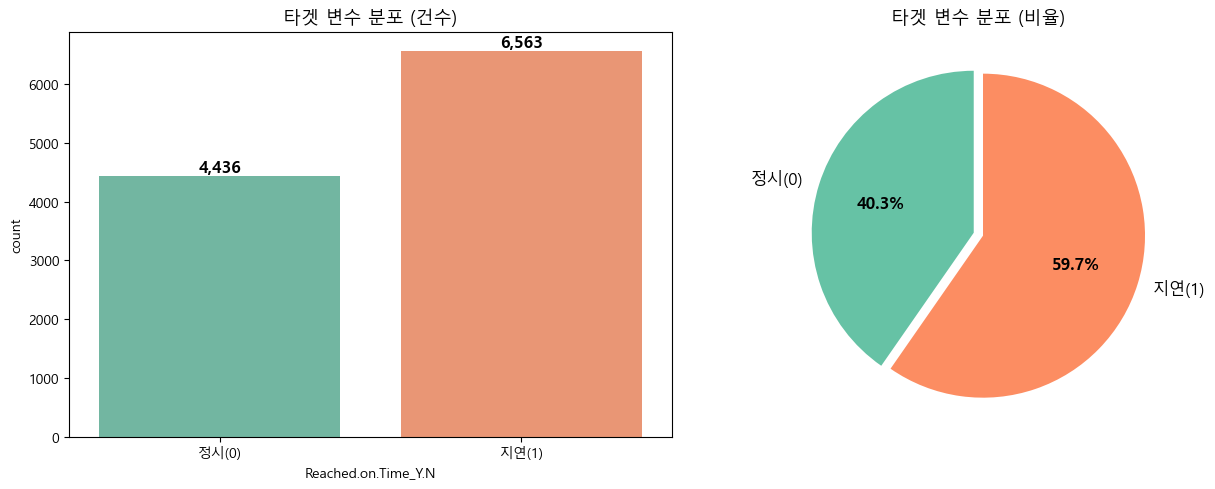

In [5]:
# 타겟 변수 분포 확인
target = 'Reached.on.Time_Y.N'

print(f"{'='*20} [Target Distribution] {'='*20}")
target_counts = df[target].value_counts()
target_pct = df[target].value_counts(normalize=True) * 100

print(f'▶ 정시 배송(0): {target_counts[0]}건 ({target_pct[0]:.1f}%)')
print(f'▶ 배송 지연(1): {target_counts[1]}건 ({target_pct[1]:.1f}%)')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# [좌] 건수 (Count)
sns.countplot(data=df, x=target, palette='Set2', ax=axes[0])
axes[0].set_title('타겟 변수 분포 (건수)', fontsize=13)
axes[0].set_xticklabels(['정시(0)', '지연(1)'])
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}',
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom', fontsize=12, fontweight='bold')

# [우] 비율 (%)
wedges, texts, autotexts = axes[1].pie(
    target_counts.sort_index(),
    labels=['정시(0)', '지연(1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set2', 2),
    explode=(0.03, 0.03),
    textprops={'fontsize': 12}
)
for t in autotexts:
    t.set_fontweight('bold')
axes[1].set_title('타겟 변수 분포 (비율)', fontsize=13)

plt.tight_layout()
plt.show()

## 4. 시각화 <a id='4-시각화'></a>

핵심 변수의 분포와 타겟 변수와의 관계를 다각도로 시각화합니다.

**분석 관점:**
1. **상관관계 히트맵**: 수치형 변수 간 상관관계 확인
2. **할인율 가설 검증**: 할인율 10% 초과 시 지연률 변화
3. **무게 구간별 분석**: 무게에 따른 배송 지연 패턴
4. **범주형 변수별 분석**: 배송수단, 창고, 중요도별 지연률

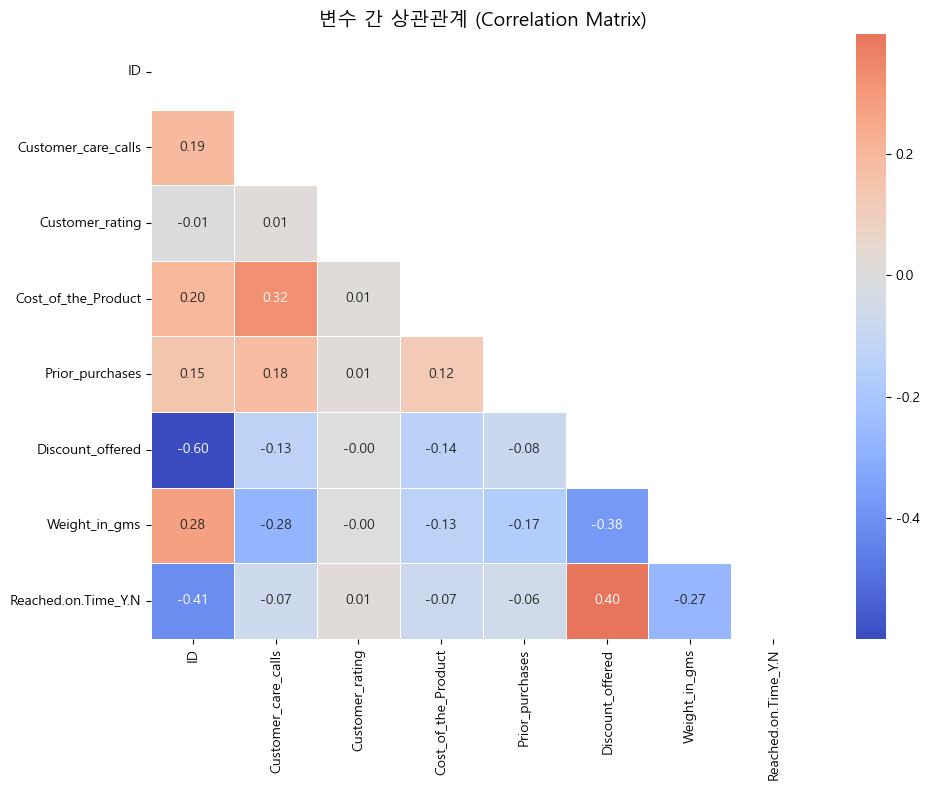

In [6]:
# 상관관계 히트맵
fig, ax = plt.subplots(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, ax=ax)
ax.set_title('변수 간 상관관계 (Correlation Matrix)', fontsize=14)
plt.tight_layout()
plt.show()

### ID vs 타겟 변수 관계 분석 (Data Leakage 검증)

상관관계 히트맵에서 **ID와 타겟(Reached.on.Time_Y.N) 간 상관계수가 -0.41**로 비정상적으로 높게 나타납니다.
ID는 단순 순번(1~10,999)이므로 본래 타겟과 무관해야 하지만, 데이터가 **타겟 기준으로 정렬된 채 ID가 부여**된 것으로 확인됩니다.

이는 **데이터 누출(Data Leakage)**에 해당하므로, ID를 피처로 사용하면 정렬 순서를 학습하게 되어 일반화 성능이 저하됩니다.
따라서 전처리 단계에서 **ID 컬럼을 반드시 제거**해야 합니다.

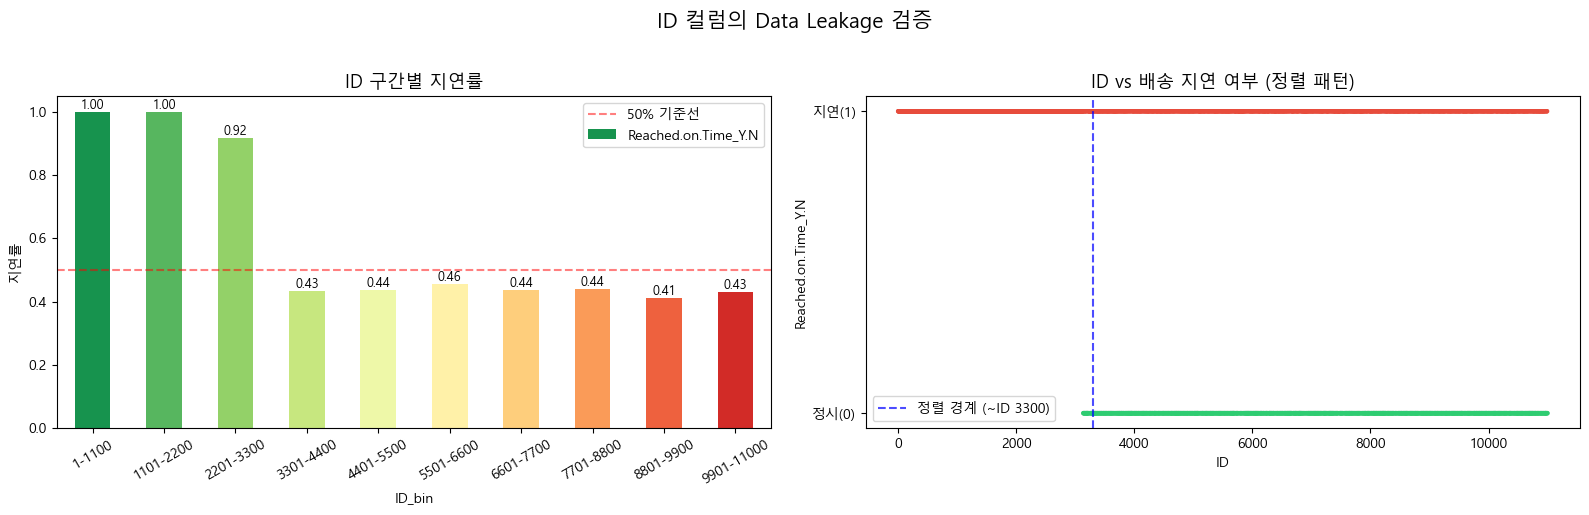

▶ ID vs 타겟 Pearson 상관계수: -0.4118
▶ ID 1~3,300 구간 지연률: 0.9721
▶ ID 3,301 이후 구간 지연률: 0.4358

=> ID는 단순 순번이지만 타겟 기준 정렬로 인해 Data Leakage 발생
=> 전처리 시 ID 컬럼 제거 필수


In [7]:
# ID vs 타겟 관계 분석: Data Leakage 검증
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# [좌] ID 구간별 지연률
temp_id = df.copy()
bins = list(range(0, 11001, 1100))  # 0, 1100, 2200, ..., 11000
labels = [f'{bins[i]+1}-{bins[i+1]}' for i in range(len(bins)-1)]
temp_id['ID_bin'] = pd.cut(temp_id['ID'], bins=bins, labels=labels)
id_rate = temp_id.groupby('ID_bin')[target].mean()

id_rate.plot(kind='bar', ax=axes[0], color=sns.color_palette('RdYlGn_r', 10))
axes[0].set_title('ID 구간별 지연률', fontsize=13)
axes[0].set_ylabel('지연률')
axes[0].set_xticklabels(labels, rotation=30)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% 기준선')
axes[0].legend()
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}',
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom', fontsize=9)

# [우] ID vs 타겟 산점도 (정렬 패턴 확인)
colors = df[target].map({0: '#2ecc71', 1: '#e74c3c'})
axes[1].scatter(df['ID'], df[target], c=colors, alpha=0.3, s=5)
axes[1].set_title('ID vs 배송 지연 여부 (정렬 패턴)', fontsize=13)
axes[1].set_xlabel('ID')
axes[1].set_ylabel('Reached.on.Time_Y.N')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['정시(0)', '지연(1)'])

# 경계선 표시
axes[1].axvline(x=3300, color='blue', linestyle='--', alpha=0.7, label='정렬 경계 (~ID 3300)')
axes[1].legend()

plt.suptitle('ID 컬럼의 Data Leakage 검증', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

# 수치 요약
corr_val = df['ID'].corr(df[target])
print(f'▶ ID vs 타겟 Pearson 상관계수: {corr_val:.4f}')
print(f'▶ ID 1~3,300 구간 지연률: {df[df["ID"] <= 3300][target].mean():.4f}')
print(f'▶ ID 3,301 이후 구간 지연률: {df[df["ID"] > 3300][target].mean():.4f}')
print(f'\n=> ID는 단순 순번이지만 타겟 기준 정렬로 인해 Data Leakage 발생')
print(f'=> 전처리 시 ID 컬럼 제거 필수')

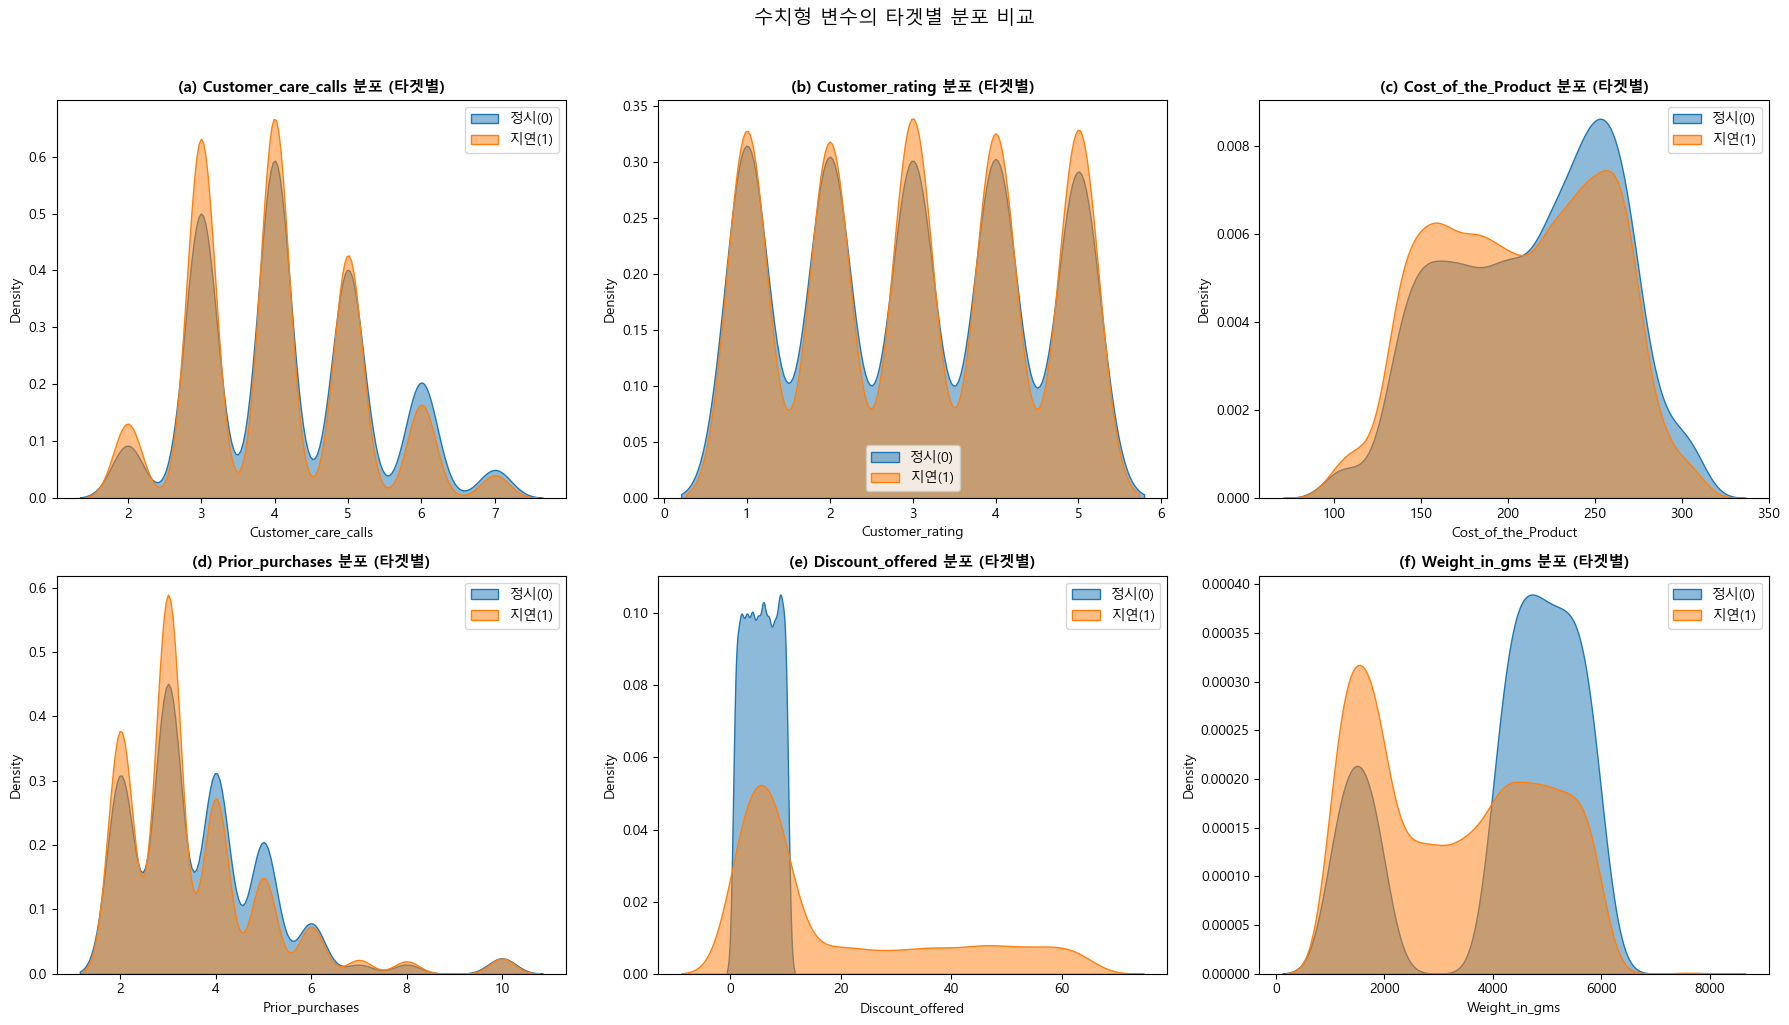

In [8]:
# 수치형 변수의 타겟별 분포
num_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
            'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for idx, col in enumerate(num_cols):
    ax = axes[idx // 3, idx % 3]
    sns.kdeplot(data=df[df[target]==0], x=col, fill=True, label='정시(0)', ax=ax, alpha=0.5)
    sns.kdeplot(data=df[df[target]==1], x=col, fill=True, label='지연(1)', ax=ax, alpha=0.5)
    ax.set_title(f'{subplot_labels[idx]} {col} 분포 (타겟별)', fontsize=11, fontweight='bold')
    ax.legend()
plt.suptitle('수치형 변수의 타겟별 분포 비교', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 수치형 변수 분포 인사이트

**(a) Customer_care_calls (고객센터 문의 횟수)**
- 문의 횟수가 많을수록 지연률이 하락하는 경향 (2회: 65% → 7회: 52%)
- 정시 그룹(0)의 평균 문의 횟수(4.15)가 지연 그룹(1)(3.99)보다 높음
- 고가 제품 + 낮은 할인 → 고객 기대치 상승 → 문의 증가 흐름으로 해석
- 단, 상관계수(-0.067)가 약하므로 단독 예측력보다는 다른 변수와의 조합 활용이 효과적

**(b) Customer_rating (고객 평점)**
- 정시/지연 두 그룹의 분포가 거의 동일하며, 평점별 지연률도 58~61%로 차이 미미
- 상관계수 +0.013으로 타겟과 **사실상 무관** → 예측에 기여도가 매우 낮은 변수

**(c) Cost_of_the_Product (제품 가격)**
- 정시 그룹(0)의 평균 가격($214.5)이 지연 그룹(1)($207.3)보다 약간 높음
- 가격 $250 이상 고가 제품의 지연률(55.4%)이 $250 미만(61.2%)보다 낮음
- 고가 제품은 배송 우선순위가 높아 지연이 상대적으로 적을 가능성 시사

**(d) Prior_purchases (이전 구매 횟수)**
- 분포 형태는 유사하지만, 구매 횟수 4~5회 구간에서 지연률이 소폭 하락
- 뚜렷한 선형 관계는 없으며 (상관계수: -0.056), 특정 구간에서만 차이 발생

**(e) Discount_offered (할인율) — 핵심 변수**
- **가장 뚜렷한 분리**를 보이는 변수 (상관계수: **+0.397**)
- 할인율 10% 이하: 지연률 46.9% / 할인율 10% 초과: **지연률 100%**
- 지연 그룹(1)의 평균 할인율(18.7%)이 정시 그룹(0)(5.6%)보다 3배 이상 높음
- 고할인 제품은 배송 우선순위가 낮거나 재고 처리 과정에서 지연이 발생하는 것으로 해석

**(f) Weight_in_gms (제품 무게) — 핵심 변수**
- 두 번째로 강한 분리력 (상관계수: **-0.269**)
- 2,000~4,000g 구간: 지연률 **99.9%** (거의 전부 지연)
- 4,000g 초과: 지연률 **43.2%** 로 급락
- 특정 무게 구간에서 배송 프로세스가 달라지는 것으로 추정 → 구간화(binning)가 유효한 변수

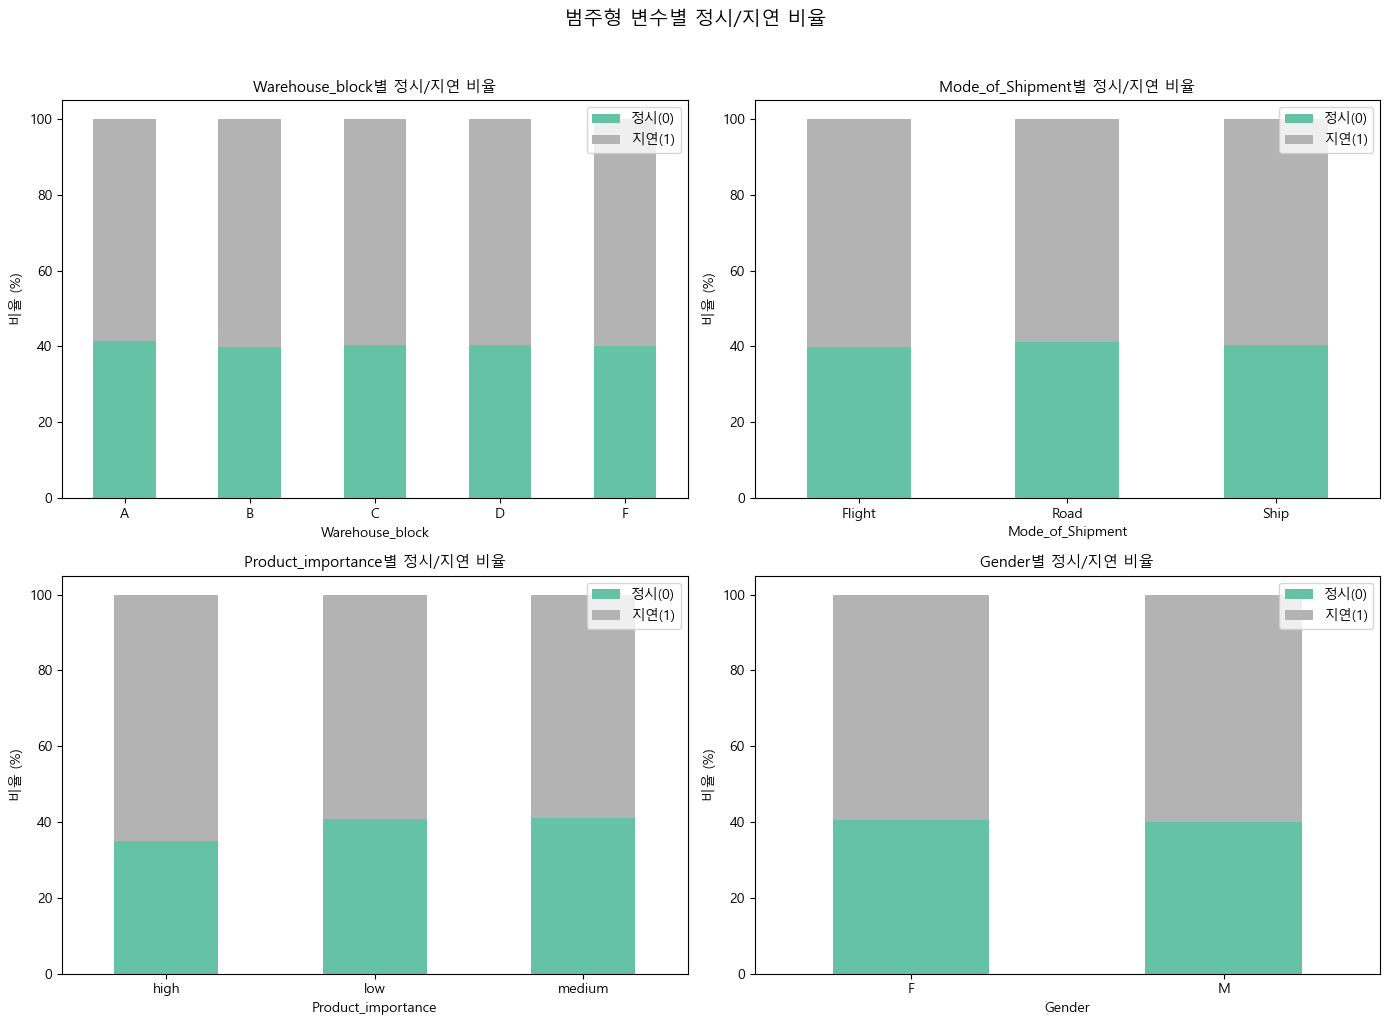

In [9]:
# 범주형 변수의 타겟별 분포
cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, col in enumerate(cat_cols):
    ax = axes[idx // 2, idx % 2]
    ct = pd.crosstab(df[col], df[target], normalize='index') * 100
    ct.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')
    ax.set_title(f'{col}별 정시/지연 비율', fontsize=11)
    ax.set_ylabel('비율 (%)')
    ax.legend(['정시(0)', '지연(1)'], loc='upper right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.suptitle('범주형 변수별 정시/지연 비율', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 범주형 변수 분포 인사이트

**Warehouse_block (창고 구역)**
- A~D는 각 1,833건으로 균등, F만 3,666건으로 2배 (전체의 33%)
- 지연률: A(58.6%) ~ B(60.2%)로 구역 간 차이가 **1.6%p에 불과**
- 창고 위치는 배송 지연에 실질적 영향 없음

**Mode_of_Shipment (배송 수단)**
- Ship(선박)이 7,462건(67.8%)으로 압도적 다수, Flight·Road는 각 ~1,770건
- 지연률: Road(58.8%) ~ Flight(60.2%)로 차이 **1.4%p에 불과**
- 배송 수단별 속도 차이가 지연 여부에 반영되지 않음 → 비현실적 (시뮬레이션 데이터 특성)

**Product_importance (제품 중요도)**
- high(948건)가 소수이며, low(5,297건)·medium(4,754건)이 대부분
- 지연률: low(59.3%), medium(59.0%), **high(65.0%)**
- 유일하게 차이가 있는 범주형 변수 (high가 약 **6%p 높음**)
- 다만 high의 건수가 적어 통계적 안정성은 낮음

**Gender (성별)**
- F(5,545건)와 M(5,454건)으로 거의 균등 분포
- 지연률: F(59.4%) vs M(59.9%)로 차이 **0.5%p에 불과**
- 성별은 배송 지연과 **완전히 무관**한 변수

**종합:** 4개 범주형 변수 모두 타겟과의 관련성이 매우 낮으며, 수치형 변수(Discount_offered, Weight_in_gms)가 예측력의 대부분을 차지합니다.
이는 시뮬레이션 데이터에서 범주형 변수가 타겟 생성 규칙에 포함되지 않았음을 의미합니다.

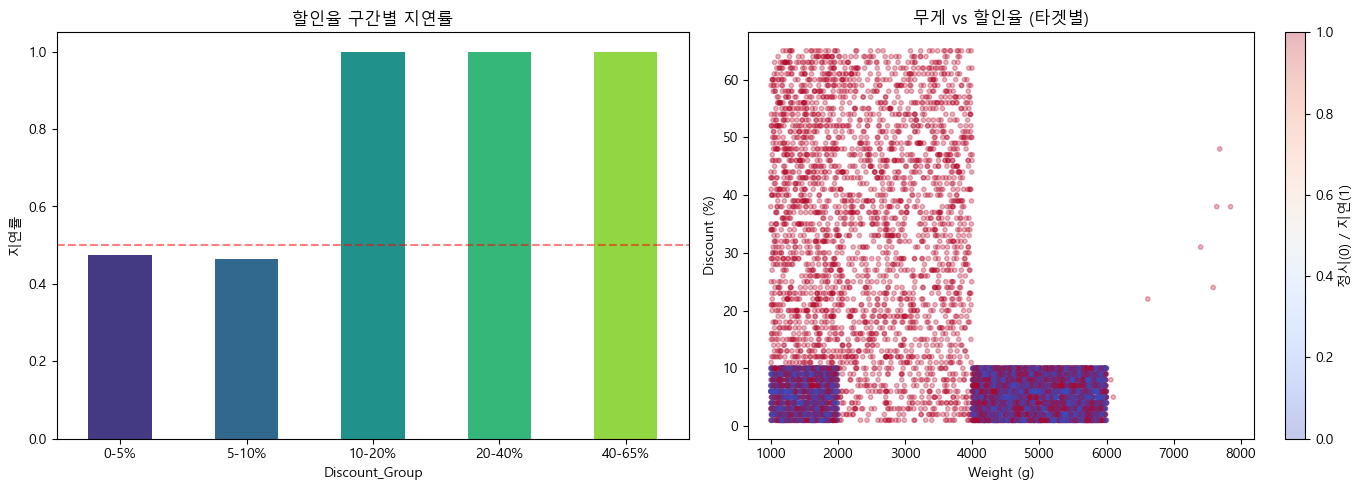

In [10]:
# 할인율 가설 검증: 할인율 10% 초과 시 지연률 변화 여부
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 할인율 구간별 지연률
temp_df = df.copy()
temp_df['Discount_Group'] = pd.cut(temp_df['Discount_offered'],
                                    bins=[0, 5, 10, 20, 40, 65],
                                    labels=['0-5%', '5-10%', '10-20%', '20-40%', '40-65%'])
discount_rate = temp_df.groupby('Discount_Group')[target].mean()
discount_rate.plot(kind='bar', ax=axes[0], color=sns.color_palette('viridis', 5))
axes[0].set_title('할인율 구간별 지연률', fontsize=12)
axes[0].set_ylabel('지연률')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)

# 무게 vs 할인율 산점도 (타겟별)
scatter = axes[1].scatter(df['Weight_in_gms'], df['Discount_offered'],
                          c=df[target], cmap='coolwarm', alpha=0.3, s=10)
axes[1].set_title('무게 vs 할인율 (타겟별)', fontsize=12)
axes[1].set_xlabel('Weight (g)')
axes[1].set_ylabel('Discount (%)')
plt.colorbar(scatter, ax=axes[1], label='정시(0) / 지연(1)')

plt.tight_layout()
plt.show()

### 할인율 & 무게 시각화 인사이트

**[좌] 할인율 구간별 지연률**
- 0~5%, 5~10% 구간: 지연률 약 **46~47%** (절반 이하)
- 10~20% 이상 모든 구간: 지연률 **정확히 100%**
- 할인율 10%를 기준으로 **비현실적인 단절(cliff)**이 발생 → 10% → 11%에서 46% → 100%로 점프
- 이는 단순한 비즈니스 패턴이 아닌, **`Discount_offered > 10` 조건으로 타겟이 결정되는 규칙** 존재를 시사

**[우] 무게 vs 할인율 산점도 — 인위적 데이터 생성 증거**

산점도에서 다음과 같은 비자연적인 패턴이 관찰됩니다:

| 무게 구간 | 할인율 범위 | 평균 할인율 | 지연률 |
|:---:|:---:|:---:|:---:|
| 1,000~2,000g | 1~65% | 16.9% | 67.8% |
| 2,000~4,000g | 1~65% | **33.0%** | **99.9%** |
| 4,000~5,000g | 1~**10%** | 5.5% | 43.7% |
| 5,000~6,000g | 1~**10%** | 5.5% | 42.5% |

- **4,000g 초과** 제품은 할인율이 **최대 10%로 잘려있음** (현실 데이터에서 나올 수 없는 패턴)
- **2,000~4,000g** 구간에 고할인 데이터가 집중 → 이 구간의 지연률이 거의 100%
- 결과적으로 `Discount_offered > 10`이면 **정시 배송 건수가 0건** (2,647건 중 0건)

**결론:** 이 데이터셋은 **교육/학습용 시뮬레이션 데이터**로, `Discount_offered > 10`이라는 단순 규칙이 타겟을 거의 완벽하게 결정합니다.
무게와 할인율 사이의 인위적 제약이 설계되어 있으므로, 비즈니스 인사이트보다는 **ML 파이프라인 연습**에 초점을 맞추는 것이 적절합니다.

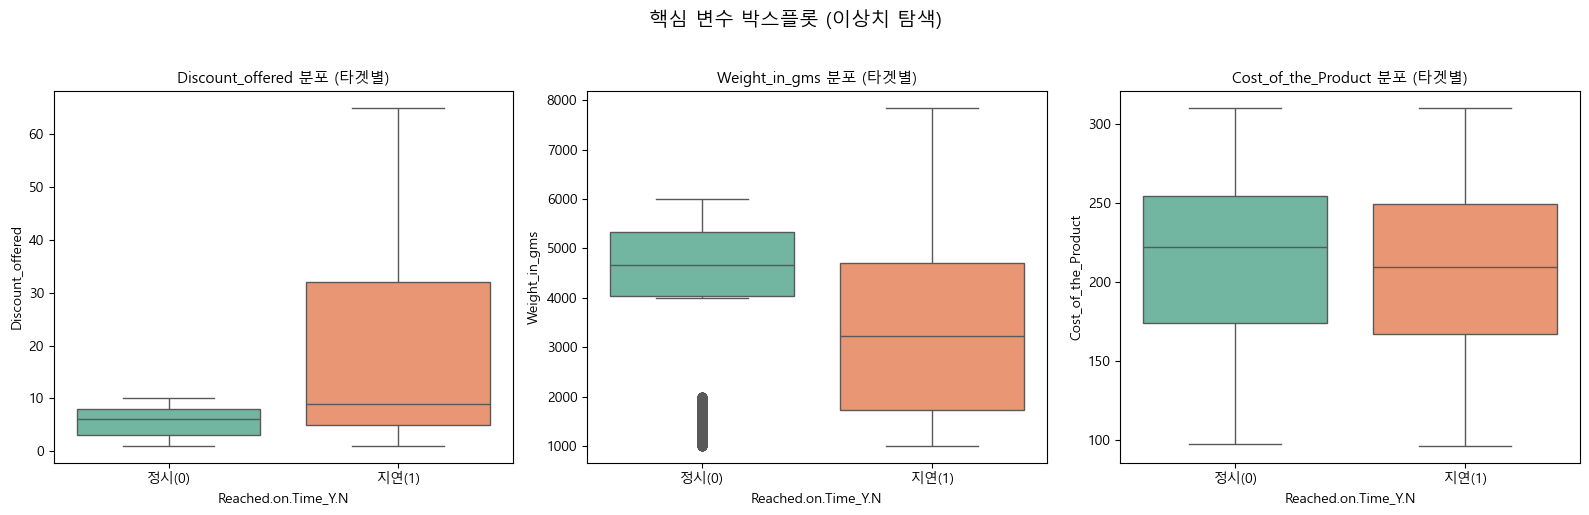

In [11]:
# 박스플롯: 이상치 탐색
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for idx, col in enumerate(['Discount_offered', 'Weight_in_gms', 'Cost_of_the_Product']):
    sns.boxplot(data=df, x=target, y=col, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{col} 분포 (타겟별)', fontsize=11)
    axes[idx].set_xticklabels(['정시(0)', '지연(1)'])
plt.suptitle('핵심 변수 박스플롯 (이상치 탐색)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 박스플롯 인사이트

**Discount_offered (할인율)**
- **정시(0)**: 할인율 범위가 1~**10%**로 완전히 잘려있음 (Q1=3, Q3=8, **최대값=10**)
- **지연(1)**: 할인율 범위가 1~65%로 넓음 (Q1=5, Q3=32)
- 정시 그룹(0)에서 할인율 >10%인 건수가 **정확히 0건** → 두 박스가 11% 이상 구간에서 전혀 겹치지 않음
- 박스플롯만으로도 `Discount_offered > 10`이 타겟을 결정하는 규칙임을 시각적으로 확인 가능

**Weight_in_gms (무게)**
- **정시(0)**: 중앙값 4,674g, 주로 4,000~6,000g에 밀집. 하단에 **이상치 1,046건(23.6%)** 표시
- **지연(1)**: 중앙값 3,231g으로 더 가볍고, 분포 범위가 넓어 이상치 0건
- 정시 그룹의 이상치(2,000g 이하)는 진짜 이상치가 아니라, 경량 제품이 정시 그룹에도 소수 포함된 것
- 정시 그룹에서 2,000~4,000g 구간은 **단 1건**뿐 → 이 역시 인위적 데이터 설계의 증거

**Cost_of_the_Product (제품 가격)**
- 두 그룹의 박스 형태가 거의 동일 (중앙값 222 vs 209, 이상치 0건)
- IQR도 80 vs 82로 유사하여, 가격만으로는 타겟 구분이 사실상 불가능
- 세 변수 중 타겟 구분 기여도가 가장 낮은 변수

## 5. 전처리 (Preprocessing) <a id='5-전처리'></a>

모델링을 위한 기본 전처리를 수행합니다.
- **ID 컬럼 제거**: 식별자이므로 분석에 불필요
- **범주형 변수 인코딩**: LabelEncoder 적용
- **데이터 분리**: 학습/테스트셋 (80:20)

In [12]:
# 원본 보존을 위한 복사
df_clean = df.copy()

# 1. ID 컬럼 제거
df_clean = df_clean.drop(columns=['ID'])
print('\u25b6 ID 컬럼 제거 완료')

# 2. 범주형 변수 인코딩 (LabelEncoder)
le_dict = {}  # 인코더 저장
cat_cols = df_clean.select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    le_dict[col] = le
    print(f'  - {col}: {list(le.classes_)} -> {list(le.transform(le.classes_))}')

print(f'\n\u25b6 인코딩 완료: {len(cat_cols)}개 변수')
display(df_clean.head(3))

▶ ID 컬럼 제거 완료
  - Warehouse_block: ['A', 'B', 'C', 'D', 'F'] -> [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
  - Mode_of_Shipment: ['Flight', 'Road', 'Ship'] -> [np.int64(0), np.int64(1), np.int64(2)]
  - Product_importance: ['high', 'low', 'medium'] -> [np.int64(0), np.int64(1), np.int64(2)]
  - Gender: ['F', 'M'] -> [np.int64(0), np.int64(1)]

▶ 인코딩 완료: 4개 변수


,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,3,0,4,2,177,3,1,0,44,1233,1
1,4,0,4,5,216,2,1,1,59,3088,1
2,0,0,2,2,183,4,1,1,48,3374,1


In [13]:
# 3. Feature / Target 분리 및 데이터셋 분할
X = df_clean.drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\u25b6 학습셋: {X_train.shape}, 테스트셋: {X_test.shape}')
print(f'\u25b6 타겟 비율 (학습): {y_train.value_counts(normalize=True).to_dict()}')

▶ 학습셋: (8799, 10), 테스트셋: (2200, 10)
▶ 타겟 비율 (학습): {1: 0.5966587112171837, 0: 0.4033412887828162}


## 6. 특성 공학 (Feature Engineering) <a id='6-특성-공학'></a>

EDA에서 발견한 인사이트를 기반으로 파생변수를 생성하여 모델 성능을 향상시킵니다.

**생성할 파생변수:**
1. `Discount_Category`: 할인율 범주화 (Low/High, 기준: 10%)
2. `Weight_Category`: 무게 구간화 (Light/Medium/Heavy_1/Heavy_2)
3. `Discount_Weight_Ratio`: 무게 대비 할인 비율
4. `Final_Cost`: 할인 적용 후 최종 가격
5. `Weight_Load_Factor`: 중요도 대비 무게 부하 지수
6. `Calls_per_Purchase`: 구매 대비 문의 비율 (신규)

In [14]:
def feature_engineering(dataframe):
    """파생변수를 생성하는 함수 (원본 데이터프레임 기반)"""
    dff = dataframe.copy()

    # 1. 할인율 범주화 (10% 기준)
    dff['Discount_Category'] = (dff['Discount_offered'] > 10).astype(int)

    # 2. 무게 구간화
    dff['Weight_Category'] = pd.cut(
        dff['Weight_in_gms'],
        bins=[0, 2000, 4000, 6000, 10000],
        labels=[0, 1, 2, 3]
    ).astype(int)

    # 3. 무게 대비 할인 비율
    dff['Discount_Weight_Ratio'] = dff['Discount_offered'] / (dff['Weight_in_gms'] + 1)

    # 4. 할인 적용 후 최종 가격
    dff['Final_Cost'] = dff['Cost_of_the_Product'] * (1 - dff['Discount_offered'] / 100)

    # 5. 중요도 대비 무게 부하 (인코딩된 값 + 1 사용)
    dff['Weight_Load_Factor'] = dff['Weight_in_gms'] / (dff['Product_importance'] + 1)

    # 6. 구매 대비 문의 비율
    dff['Calls_per_Purchase'] = dff['Customer_care_calls'] / (dff['Prior_purchases'] + 1)

    return dff

# 파생변수 적용
X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)

print(f'\u25b6 파생변수 생성 완료')
print(f'  - 기본 변수: {X_train.shape[1]}개 -> 파생변수 포함: {X_train_fe.shape[1]}개')
print(f'  - 추가된 변수: {list(set(X_train_fe.columns) - set(X_train.columns))}')

▶ 파생변수 생성 완료
  - 기본 변수: 10개 -> 파생변수 포함: 16개
  - 추가된 변수: ['Weight_Load_Factor', 'Discount_Category', 'Calls_per_Purchase', 'Discount_Weight_Ratio', 'Weight_Category', 'Final_Cost']


In [15]:
# 스케일링 (StandardScaler) - 트리 계열이 아닌 모델을 위해
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_fe),
    columns=X_train_fe.columns,
    index=X_train_fe.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_fe),
    columns=X_test_fe.columns,
    index=X_test_fe.index
)

print('\u25b6 스케일링 완료 (StandardScaler)')
display(X_train_scaled.head(3))

▶ 스케일링 완료 (StandardScaler)


,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Discount_Category,Weight_Category,Discount_Weight_Ratio,Final_Cost,Weight_Load_Factor,Calls_per_Purchase
7920,0.452459,-0.685120,-0.043121,-1.415468,1.056631,-1.032208,1.031948,-0.982984,-0.270466,0.322365,-0.564444,0.855056,-0.404312,0.956382,-0.305381,1.211170
1529,1.123597,0.636601,-0.921405,0.001852,-1.003783,-1.032208,-0.547202,-0.982984,0.782420,-1.206929,1.771654,-1.414860,1.048955,-1.114564,-0.812641,0.166419
10521,-0.889816,0.636601,-0.921405,-0.706808,0.224140,-1.032208,1.031948,1.017311,-0.270466,0.510849,-0.564444,0.855056,-0.420375,0.315538,-0.211799,0.166419


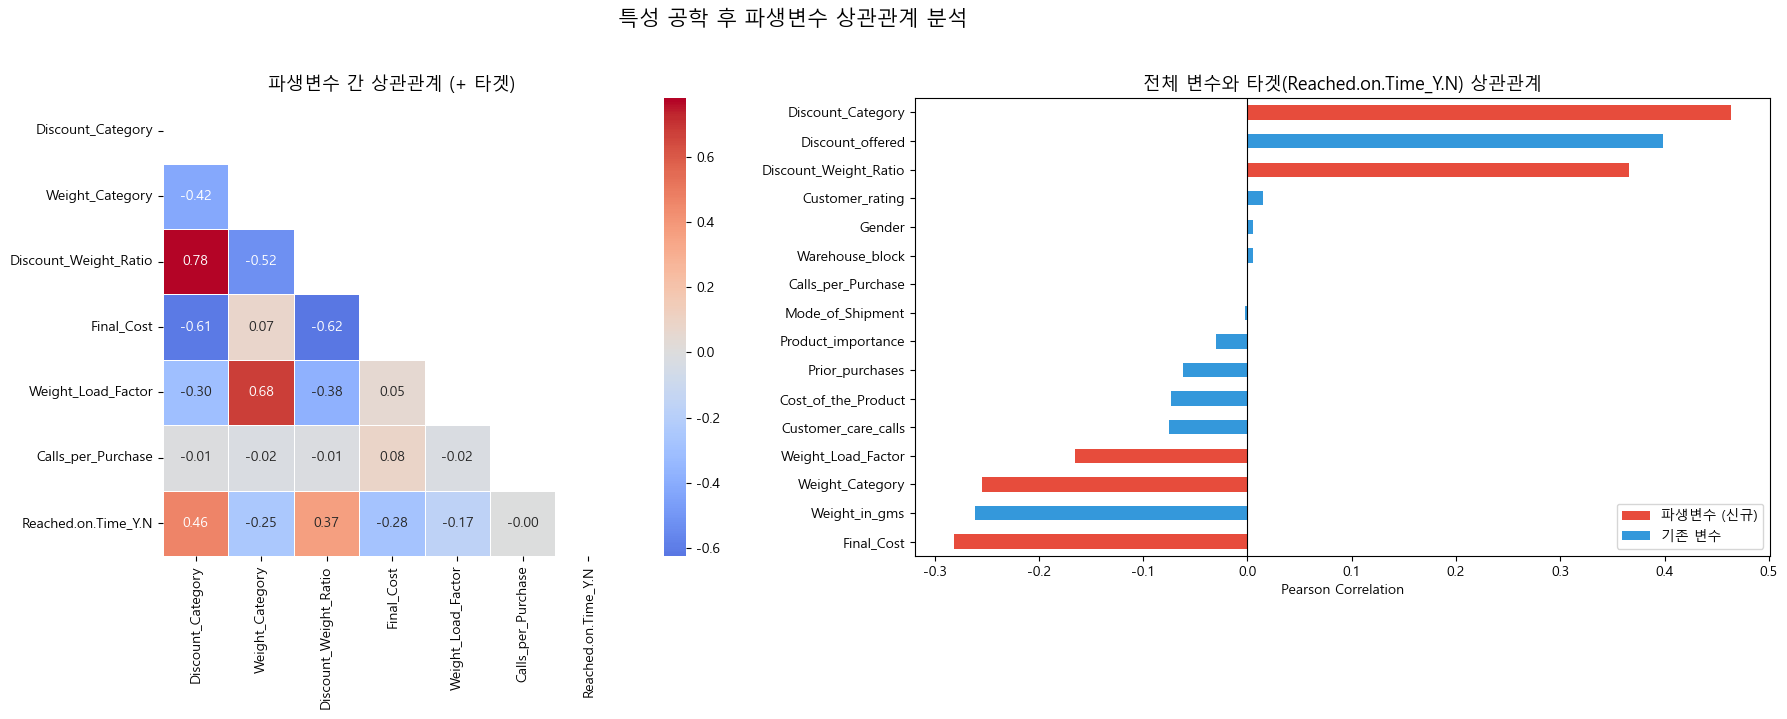

▶ 파생변수 vs 타겟 상관관계:
  - Discount_Category        : +0.4641
  - Weight_Category          : -0.2547
  - Discount_Weight_Ratio    : +0.3662
  - Final_Cost               : -0.2816
  - Weight_Load_Factor       : -0.1658
  - Calls_per_Purchase       : -0.0003


In [16]:
# 파생변수 상관관계 히트맵 (타겟 포함)
new_cols = ['Discount_Category', 'Weight_Category', 'Discount_Weight_Ratio',
            'Final_Cost', 'Weight_Load_Factor', 'Calls_per_Purchase']

# 파생변수 + 타겟을 합쳐서 상관관계 확인
fe_corr_df = X_train_fe[new_cols].copy()
fe_corr_df[target] = y_train.values

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# [좌] 파생변수 간 상관관계
corr_new = fe_corr_df.corr()
mask = np.triu(np.ones_like(corr_new, dtype=bool))
sns.heatmap(corr_new, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            linewidths=0.5, mask=mask, ax=axes[0], square=True)
axes[0].set_title('파생변수 간 상관관계 (+ 타겟)', fontsize=13)

# [우] 전체 변수(기존 + 파생) vs 타겟 상관관계 (바 차트)
full_corr_df = X_train_fe.copy()
full_corr_df[target] = y_train.values
target_corr = full_corr_df.corr()[target].drop(target).sort_values()

colors = ['#e74c3c' if col in new_cols else '#3498db' for col in target_corr.index]
target_corr.plot(kind='barh', ax=axes[1], color=colors)
axes[1].set_title(f'전체 변수와 타겟({target}) 상관관계', fontsize=13)
axes[1].set_xlabel('Pearson Correlation')
axes[1].axvline(x=0, color='black', linewidth=0.8)

# 범례
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='파생변수 (신규)'),
                   Patch(facecolor='#3498db', label='기존 변수')]
axes[1].legend(handles=legend_elements, loc='lower right')

plt.suptitle('특성 공학 후 파생변수 상관관계 분석', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

print('\u25b6 파생변수 vs 타겟 상관관계:')
for col in new_cols:
    corr_val = full_corr_df[col].corr(full_corr_df[target])
    print(f'  - {col:25s}: {corr_val:+.4f}')

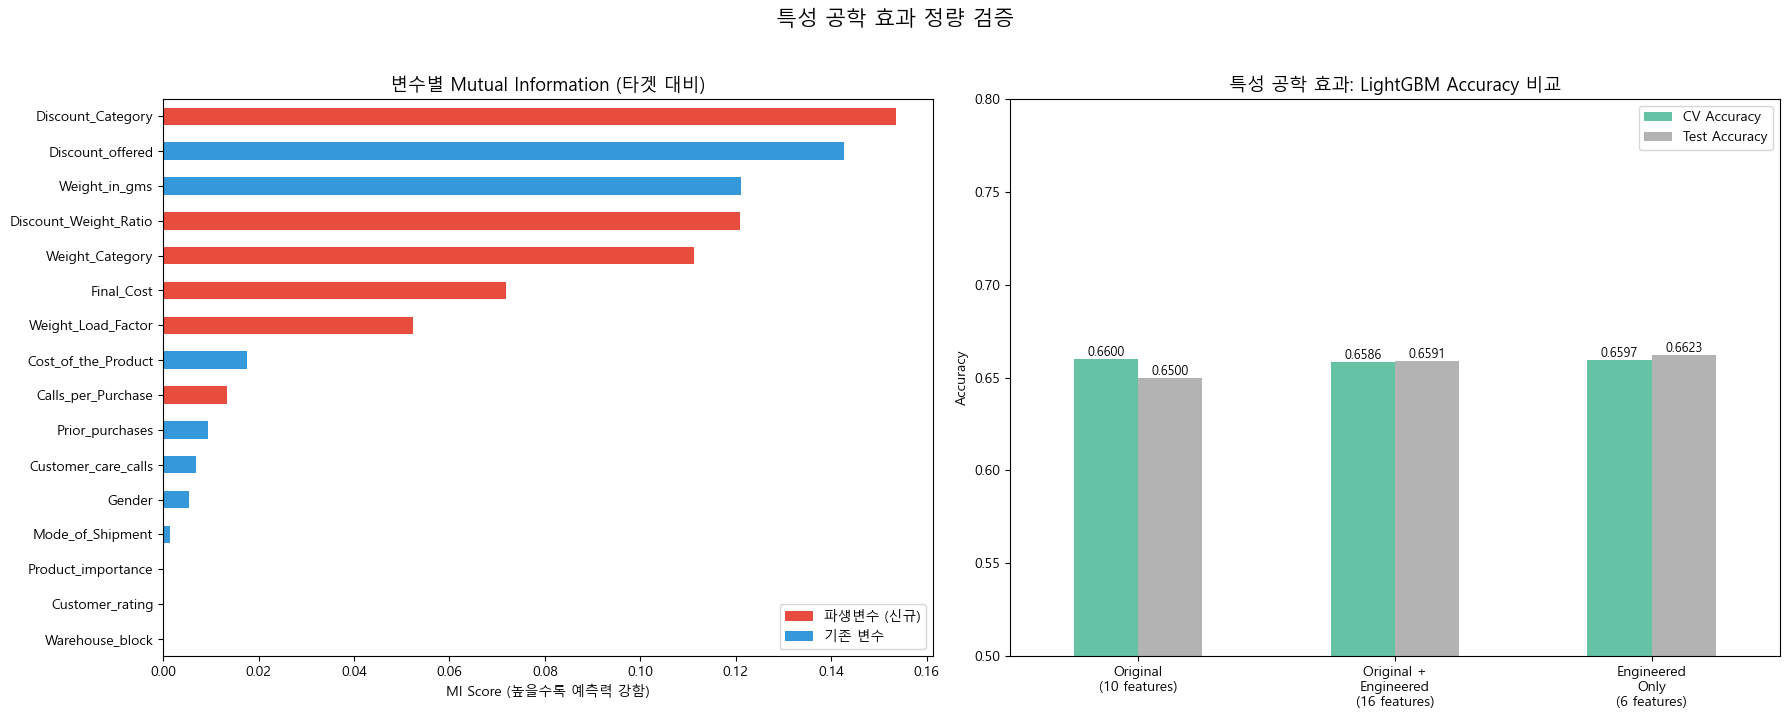

▶ [Mutual Information 상위 5개 변수]
   1. Discount_Category        : 0.1536 (신규)
   2. Discount_offered         : 0.1427 (기존)
   3. Weight_in_gms            : 0.1212 (기존)
   4. Discount_Weight_Ratio    : 0.1208 (신규)
   5. Weight_Category          : 0.1113 (신규)

▶ [LightGBM Accuracy 비교]
   Original (10 features)              | CV: 0.6600 | Test: 0.6500
   Original + Engineered (16 features) | CV: 0.6586 | Test: 0.6591
   Engineered Only (6 features)        | CV: 0.6597 | Test: 0.6623


In [17]:
# ===== 특성 공학 효과 정량 검증 =====
from sklearn.feature_selection import mutual_info_classif

new_cols = ['Discount_Category', 'Weight_Category', 'Discount_Weight_Ratio',
            'Final_Cost', 'Weight_Load_Factor', 'Calls_per_Purchase']
original_cols = [c for c in X_train_fe.columns if c not in new_cols]

# 1. Mutual Information: 각 변수가 타겟을 얼마나 잘 구분하는지 (비선형 포함)
mi_scores = pd.Series(
    mutual_info_classif(X_train_fe, y_train, random_state=42),
    index=X_train_fe.columns
).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# [좌] Mutual Information 비교
colors_mi = ['#e74c3c' if col in new_cols else '#3498db' for col in mi_scores.index]
mi_scores.plot(kind='barh', ax=axes[0], color=colors_mi)
axes[0].set_title('변수별 Mutual Information (타겟 대비)', fontsize=13)
axes[0].set_xlabel('MI Score (높을수록 예측력 강함)')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='파생변수 (신규)'),
                   Patch(facecolor='#3498db', label='기존 변수')]
axes[0].legend(handles=legend_elements, loc='lower right')

# [우] 기존 vs 파생변수 모델 성능 비교 (LightGBM 기준)
lgbm_eval = LGBMClassifier(random_state=42, verbose=-1, n_jobs=N_JOBS)
skf_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 스케일링 적용
scaler_orig = StandardScaler()
X_orig_scaled = pd.DataFrame(scaler_orig.fit_transform(X_train[original_cols]), columns=original_cols, index=X_train.index)
X_orig_test_scaled = pd.DataFrame(scaler_orig.transform(X_test[original_cols]), columns=original_cols, index=X_test.index)

datasets = {
    'Original\n(10 features)': (X_orig_scaled, X_orig_test_scaled),
    'Original +\nEngineered\n(16 features)': (X_train_scaled, X_test_scaled),
    'Engineered\nOnly\n(6 features)': (
        pd.DataFrame(StandardScaler().fit_transform(X_train_fe[new_cols]), columns=new_cols, index=X_train_fe.index),
        pd.DataFrame(StandardScaler().fit_transform(X_test_fe[new_cols]), columns=new_cols, index=X_test_fe.index)
    ),
}

acc_results = {}
for name, (X_tr, X_te) in datasets.items():
    cv = cross_val_score(lgbm_eval, X_tr, y_train, cv=skf_eval, scoring='accuracy')
    lgbm_eval.fit(X_tr, y_train)
    test_acc = accuracy_score(y_test, lgbm_eval.predict(X_te))
    acc_results[name] = {'CV Accuracy': cv.mean(), 'Test Accuracy': test_acc}

acc_df = pd.DataFrame(acc_results).T
acc_df.plot(kind='bar', ax=axes[1], rot=0, colormap='Set2')
axes[1].set_title('특성 공학 효과: LightGBM Accuracy 비교', fontsize=13)
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.5, 0.8)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.4f', fontsize=9)

plt.suptitle('특성 공학 효과 정량 검증', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

# 수치 요약
print('▶ [Mutual Information 상위 5개 변수]')
for i, (feat, score) in enumerate(mi_scores.sort_values(ascending=False).head(5).items(), 1):
    tag = '(신규)' if feat in new_cols else '(기존)'
    print(f'   {i}. {feat:25s}: {score:.4f} {tag}')

print(f'\n▶ [LightGBM Accuracy 비교]')
for name, scores in acc_results.items():
    label = name.replace('\n', ' ')
    print(f'   {label:35s} | CV: {scores["CV Accuracy"]:.4f} | Test: {scores["Test Accuracy"]:.4f}')

## 7. 모델링 (Baseline) <a id='7-모델링'></a>

6개 모델의 **기본(default) 하이퍼파라미터**로 Baseline 성능을 측정합니다.
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM
- CatBoost

In [18]:
# Baseline 모델 정의 (GPU 지원 모델은 USE_GPU에 따라 분기)
xgb_params = {'eval_metric': 'logloss', 'random_state': 42, 'verbosity': 0, 'n_jobs': N_JOBS}
lgbm_params = {'random_state': 42, 'verbose': -1, 'n_jobs': N_JOBS}
cat_params = {'random_state': 42, 'verbose': 0, 'thread_count': N_JOBS}

if USE_GPU:
    xgb_params.update({'tree_method': 'hist', 'device': 'cuda'})
    lgbm_params.update({'device': 'gpu'})
    cat_params.update({'task_type': 'GPU'})

baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=N_JOBS),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=N_JOBS),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(**xgb_params),
    'LightGBM': LGBMClassifier(**lgbm_params),
    'CatBoost': CatBoostClassifier(**cat_params),
}

# Baseline 성능 측정
baseline_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in baseline_models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    baseline_results.append({
        'Model': name,
        'CV Accuracy (Mean)': cv_scores.mean(),
        'CV Accuracy (Std)': cv_scores.std(),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred),
        'Test AUC': roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]) if hasattr(model, 'predict_proba') else None
    })
    print(f'▶ {name:25s} | CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f}) | Test: {accuracy_score(y_test, y_pred):.4f}')

baseline_df = pd.DataFrame(baseline_results).sort_values('Test Accuracy', ascending=False)
print(f"\n{'='*70}")
display(baseline_df)

▶ Logistic Regression       | CV: 0.6596 (+/- 0.0079) | Test: 0.6732
▶ Random Forest             | CV: 0.6530 (+/- 0.0180) | Test: 0.6564
▶ Gradient Boosting         | CV: 0.6760 (+/- 0.0131) | Test: 0.6800
▶ XGBoost                   | CV: 0.6512 (+/- 0.0167) | Test: 0.6532
▶ LightGBM                  | CV: 0.6586 (+/- 0.0105) | Test: 0.6591
▶ CatBoost                  | CV: 0.6553 (+/- 0.0057) | Test: 0.6559



,Model,CV Accuracy (Mean),CV Accuracy (Std),Test Accuracy,Test F1,Test AUC
2,Gradient Boosting,0.675986,0.013118,0.680000,0.660232,0.751037
0,Logistic Regression,0.659620,0.007932,0.673182,0.682841,0.739655
4,LightGBM,0.658598,0.010525,0.659091,0.673345,0.724524
1,Random Forest,0.653030,0.018012,0.656364,0.681282,0.734252
5,CatBoost,0.655302,0.005729,0.655909,0.665192,0.729077
3,XGBoost,0.651210,0.016738,0.653182,0.687935,0.736786


## 8. 하이퍼파라미터 튜닝 (Optuna) <a id='8-하이퍼파라미터-튜닝'></a>

**Optuna**를 사용하여 각 모델의 하이퍼파라미터를 최적화합니다.

**Optuna의 장점:**
- **TPE(Tree-structured Parzen Estimator)** 기반 효율적 탐색
- **Pruning**: 성능이 낮은 trial을 조기 종료
- **파라미터 중요도** 시각화 지원

In [19]:
# ===== 1. Random Forest 튜닝 =====
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': N_JOBS
    }
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    return scores.mean()

study_rf = optuna.create_study(direction='maximize', study_name='RandomForest')
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print(f'▶ [Random Forest] 최적 CV Accuracy: {study_rf.best_value:.4f}')
print(f'  최적 파라미터: {study_rf.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]

▶ [Random Forest] 최적 CV Accuracy: 0.6870
  최적 파라미터: {'n_estimators': 350, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}


In [20]:
# ===== 2. XGBoost 튜닝 =====
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eval_metric': 'logloss',
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': N_JOBS
    }
    if USE_GPU:
        params.update({'tree_method': 'hist', 'device': 'cuda'})
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    return scores.mean()

study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost')
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print(f'▶ [XGBoost] 최적 CV Accuracy: {study_xgb.best_value:.4f}')
print(f'  최적 파라미터: {study_xgb.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]

▶ [XGBoost] 최적 CV Accuracy: 0.6851
  최적 파라미터: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.013445977260435577, 'subsample': 0.6369553283181696, 'colsample_bytree': 0.7115203100325178, 'reg_alpha': 4.33341894564271, 'reg_lambda': 2.2598564975466817, 'min_child_weight': 7}


In [21]:
# ===== 3. LightGBM 튜닝 =====
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': N_JOBS
    }
    if USE_GPU:
        params.update({'device': 'gpu'})
    model = LGBMClassifier(**params)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize', study_name='LightGBM')
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

print(f'▶ [LightGBM] 최적 CV Accuracy: {study_lgbm.best_value:.4f}')
print(f'  최적 파라미터: {study_lgbm.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]

▶ [LightGBM] 최적 CV Accuracy: 0.6835
  최적 파라미터: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.010678971070255732, 'num_leaves': 59, 'subsample': 0.5445041823832191, 'colsample_bytree': 0.756901530178349, 'reg_alpha': 4.875865486628298e-05, 'reg_lambda': 0.10344778097538315, 'min_child_samples': 32}


In [22]:
# ===== 4. CatBoost 튜닝 =====
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_state': 42,
        'verbose': 0,
        'thread_count': N_JOBS
    }
    if USE_GPU:
        params.update({'task_type': 'GPU'})
    model = CatBoostClassifier(**params)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    return scores.mean()

study_cat = optuna.create_study(direction='maximize', study_name='CatBoost')
study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=True)

print(f'▶ [CatBoost] 최적 CV Accuracy: {study_cat.best_value:.4f}')
print(f'  최적 파라미터: {study_cat.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]

▶ [CatBoost] 최적 CV Accuracy: 0.6870
  최적 파라미터: {'iterations': 150, 'depth': 6, 'learning_rate': 0.0146852419290457, 'l2_leaf_reg': 0.0024150485495462674, 'bagging_temperature': 0.8437946113475291, 'border_count': 32}


In [23]:
# ===== 5. Gradient Boosting 튜닝 =====
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }
    model = GradientBoostingClassifier(**params)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    return scores.mean()

study_gb = optuna.create_study(direction='maximize', study_name='GradientBoosting')
study_gb.optimize(objective_gb, n_trials=50, show_progress_bar=True)

print(f'\u25b6 [Gradient Boosting] 최적 CV Accuracy: {study_gb.best_value:.4f}')
print(f'  최적 파라미터: {study_gb.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]

▶ [Gradient Boosting] 최적 CV Accuracy: 0.6804
  최적 파라미터: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01946436931909625, 'subsample': 0.6330615020682239, 'min_samples_split': 12, 'min_samples_leaf': 6}


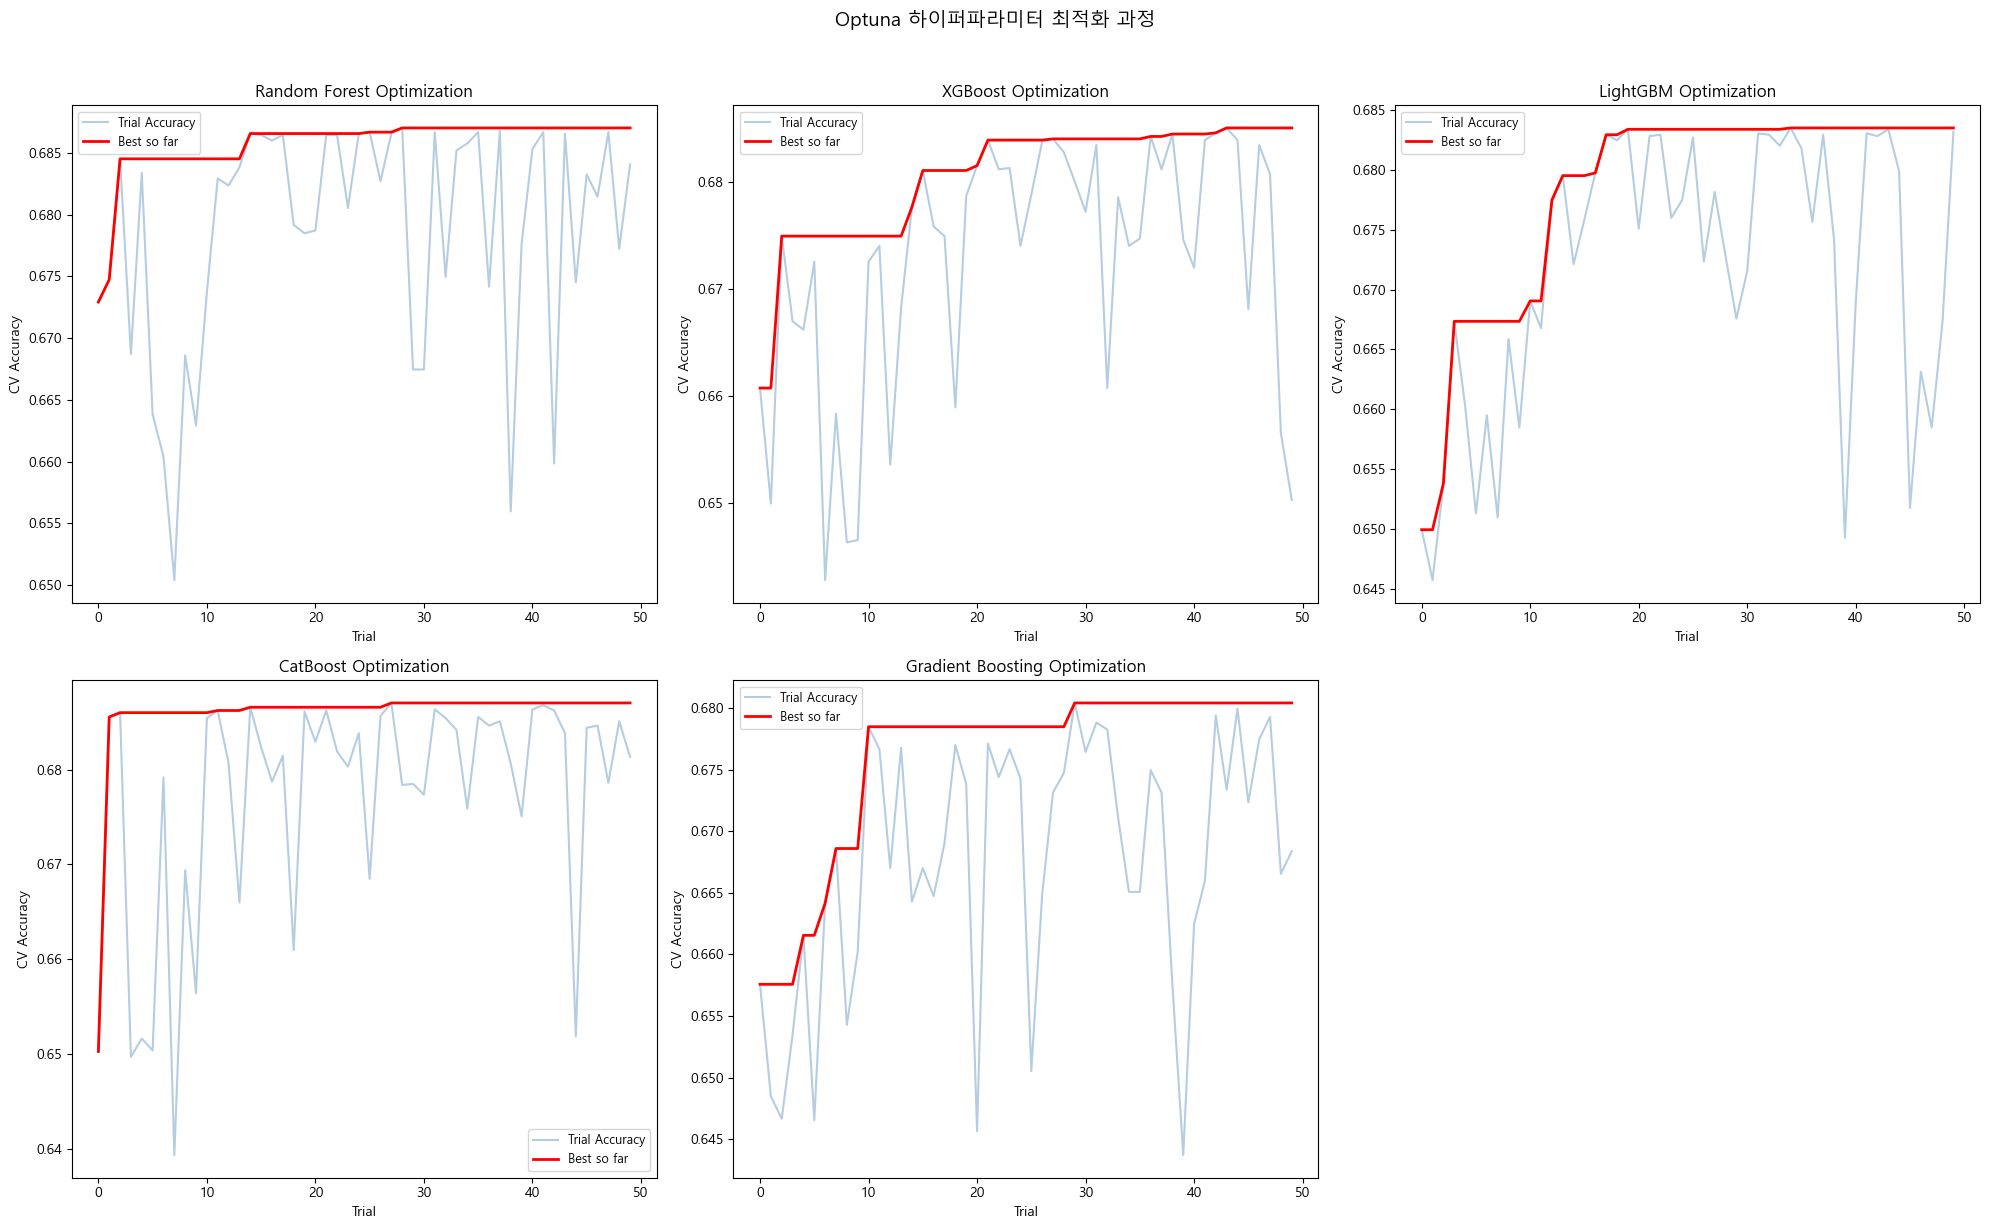

In [24]:
# Optuna 최적화 과정 시각화
studies = {
    'Random Forest': study_rf,
    'XGBoost': study_xgb,
    'LightGBM': study_lgbm,
    'CatBoost': study_cat,
    'Gradient Boosting': study_gb
}

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, study) in enumerate(studies.items()):
    trials = [t.value for t in study.trials]
    best_so_far = [max(trials[:i+1]) for i in range(len(trials))]
    axes[idx].plot(trials, alpha=0.4, label='Trial Accuracy', color='steelblue')
    axes[idx].plot(best_so_far, color='red', linewidth=2, label='Best so far')
    axes[idx].set_title(f'{name} Optimization', fontsize=12)
    axes[idx].set_xlabel('Trial')
    axes[idx].set_ylabel('CV Accuracy')
    axes[idx].legend(fontsize=9)

axes[-1].axis('off')  # 마지막 빈 subplot 숨기기
plt.suptitle('Optuna 하이퍼파라미터 최적화 과정', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. 모델 비교 평가 <a id='9-모델-비교-평가'></a>

Optuna로 최적화된 파라미터를 적용한 최종 모델의 성능을 종합 비교합니다.

**평가 지표:**
- Accuracy, F1-Score, Precision, Recall, AUC-ROC
- Confusion Matrix
- ROC Curve
- Feature Importance

In [25]:
# 최적 파라미터로 최종 모델 학습 (GPU + CPU 코어 제한 옵션 포함)
xgb_final_params = {**study_xgb.best_params, 'eval_metric': 'logloss', 'random_state': 42, 'verbosity': 0, 'n_jobs': N_JOBS}
lgbm_final_params = {**study_lgbm.best_params, 'random_state': 42, 'verbose': -1, 'n_jobs': N_JOBS}
cat_final_params = {**study_cat.best_params, 'random_state': 42, 'verbose': 0, 'thread_count': N_JOBS}

if USE_GPU:
    xgb_final_params.update({'tree_method': 'hist', 'device': 'cuda'})
    lgbm_final_params.update({'device': 'gpu'})
    cat_final_params.update({'task_type': 'GPU'})

final_models = {
    'Random Forest': RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=N_JOBS),
    'XGBoost': XGBClassifier(**xgb_final_params),
    'LightGBM': LGBMClassifier(**lgbm_final_params),
    'CatBoost': CatBoostClassifier(**cat_final_params),
    'Gradient Boosting': GradientBoostingClassifier(**study_gb.best_params, random_state=42),
}

final_results = []

for name, model in final_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    final_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    })
    print(f'▶ {name:25s} | Acc: {accuracy_score(y_test, y_pred):.4f} | F1: {f1_score(y_test, y_pred):.4f} | AUC: {roc_auc_score(y_test, y_proba):.4f}')

final_df = pd.DataFrame(final_results).sort_values('Accuracy', ascending=False)
print(f"\n{'='*80}")
print('▶ [Optuna 튜닝 후 최종 성능 비교]')
display(final_df)

▶ Random Forest             | Acc: 0.6800 | F1: 0.6455 | AUC: 0.7559
▶ XGBoost                   | Acc: 0.6773 | F1: 0.6425 | AUC: 0.7537
▶ LightGBM                  | Acc: 0.6786 | F1: 0.6417 | AUC: 0.7542
▶ CatBoost                  | Acc: 0.6768 | F1: 0.6378 | AUC: 0.7488
▶ Gradient Boosting         | Acc: 0.6805 | F1: 0.6504 | AUC: 0.7535

▶ [Optuna 튜닝 후 최종 성능 비교]


,Model,Accuracy,F1-Score,Precision,Recall,AUC-ROC
4,Gradient Boosting,0.680455,0.650423,0.936963,0.498096,0.753462
0,Random Forest,0.680000,0.645519,0.952452,0.488195,0.755928
2,LightGBM,0.678636,0.641662,0.959091,0.482102,0.754226
1,XGBoost,0.677273,0.642497,0.947994,0.485910,0.753698
3,CatBoost,0.676818,0.637799,0.963077,0.476771,0.748811


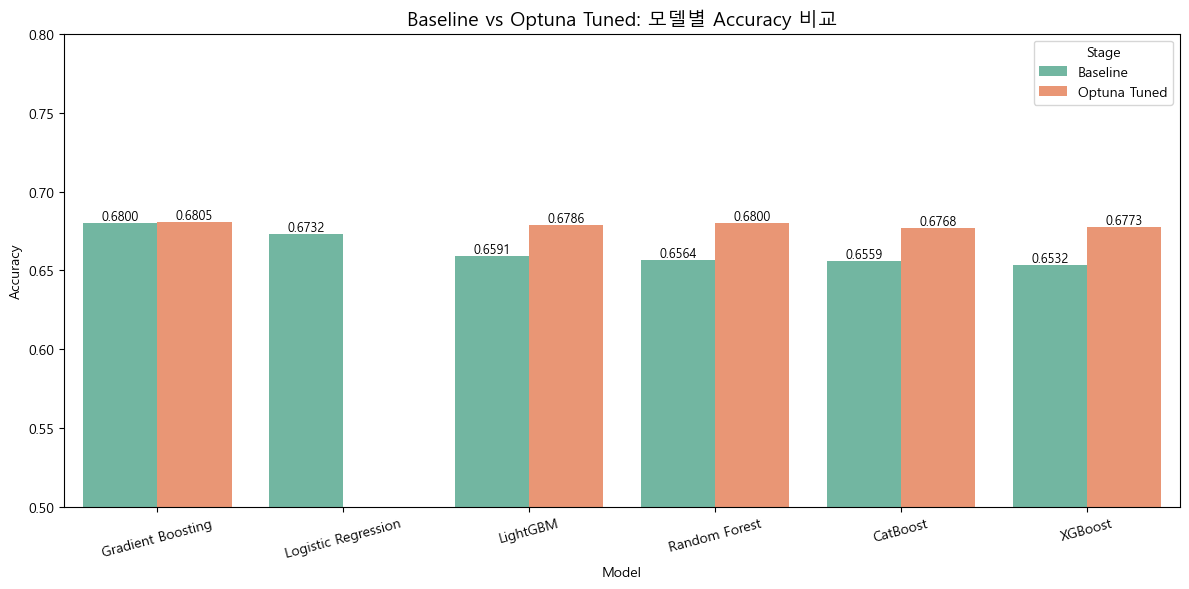

In [26]:
# Baseline vs Optuna 성능 비교 시각화
comparison_data = []
for _, row in baseline_df.iterrows():
    model_name = row['Model']
    comparison_data.append({'Model': model_name, 'Stage': 'Baseline', 'Accuracy': row['Test Accuracy']})

for _, row in final_df.iterrows():
    model_name = row['Model']
    comparison_data.append({'Model': model_name, 'Stage': 'Optuna Tuned', 'Accuracy': row['Accuracy']})

comp_df = pd.DataFrame(comparison_data)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=comp_df, x='Model', y='Accuracy', hue='Stage', palette='Set2', ax=ax)
ax.set_title('Baseline vs Optuna Tuned: 모델별 Accuracy 비교', fontsize=14)
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=9)
plt.tight_layout()
plt.show()

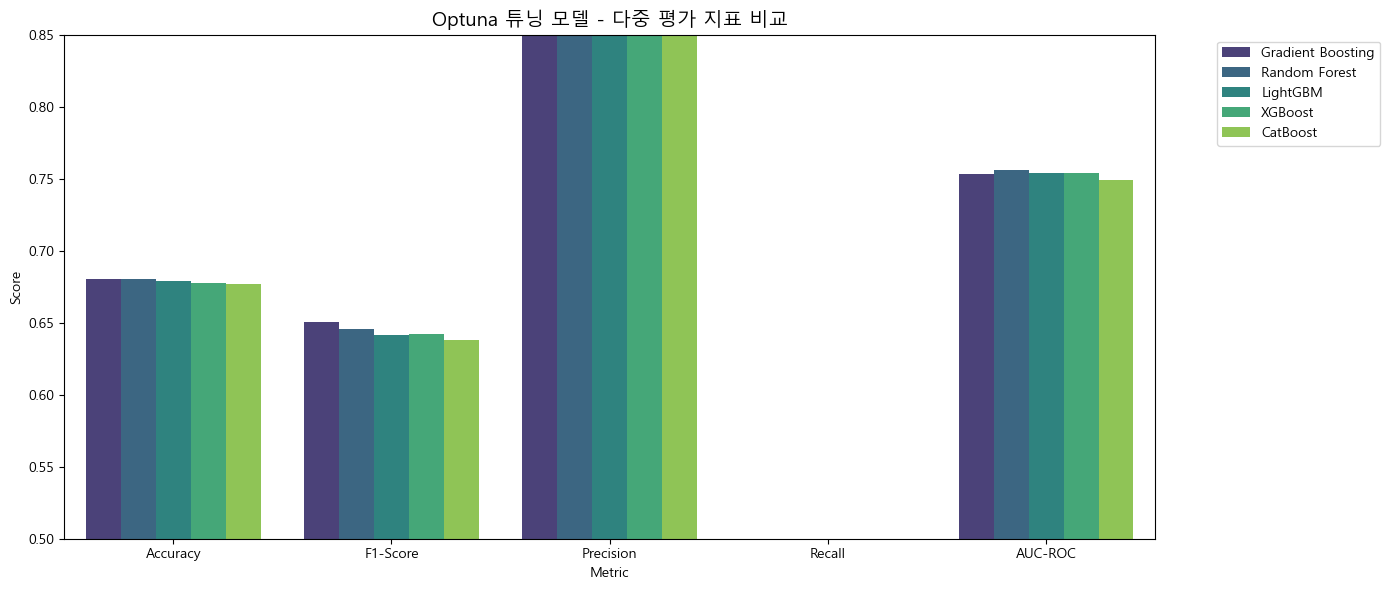

In [27]:
# 다중 지표 비교 (레이더 차트 스타일 - 바 차트)
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC-ROC']
melted = final_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=melted, x='Metric', y='Score', hue='Model', palette='viridis', ax=ax)
ax.set_title('Optuna 튜닝 모델 - 다중 평가 지표 비교', fontsize=14)
ax.set_ylim(0.5, 0.85)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

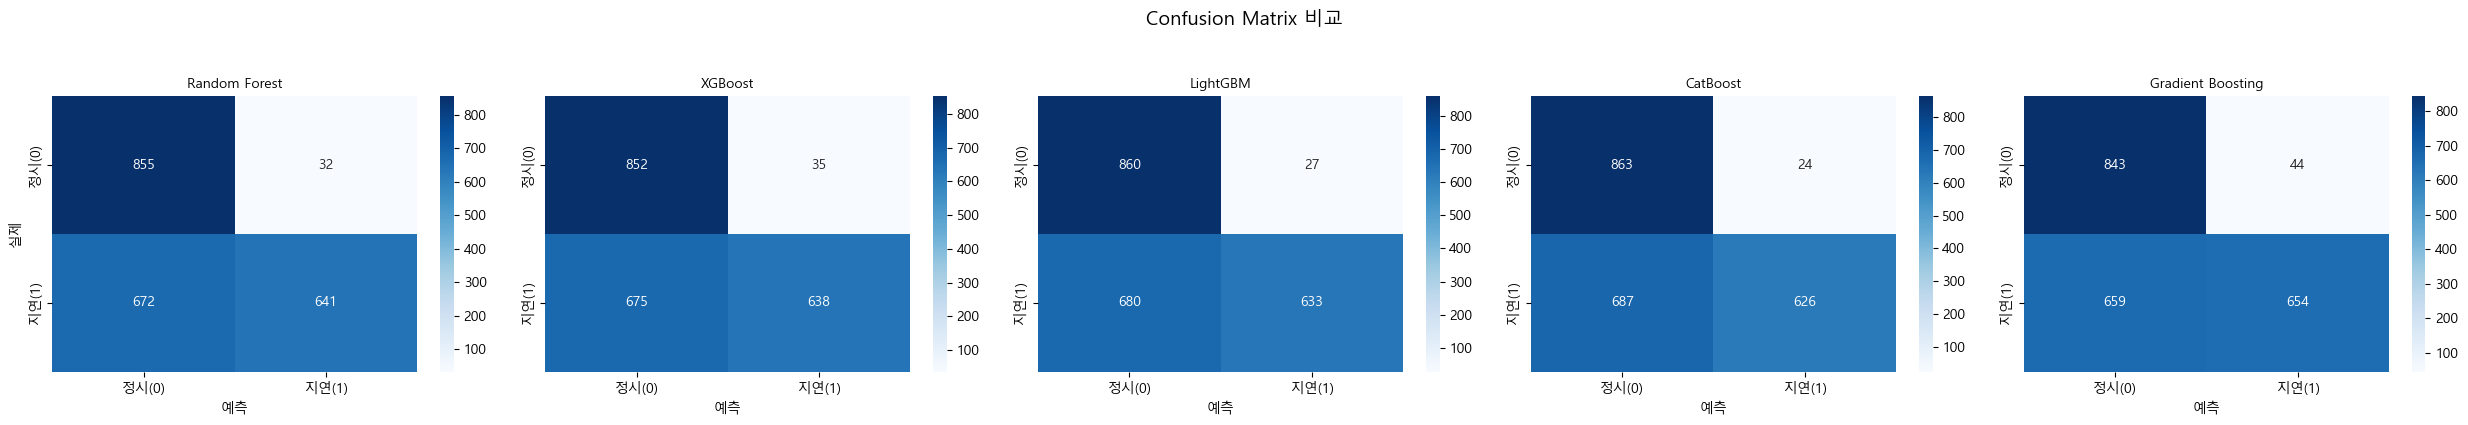

In [28]:
# Confusion Matrix (최종 모델들)
fig, axes = plt.subplots(1, 5, figsize=(25, 4))
for idx, (name, model) in enumerate(final_models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['정시(0)', '지연(1)'], yticklabels=['정시(0)', '지연(1)'])
    axes[idx].set_title(f'{name}', fontsize=10)
    axes[idx].set_ylabel('실제' if idx == 0 else '')
    axes[idx].set_xlabel('예측')
plt.suptitle('Confusion Matrix 비교', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

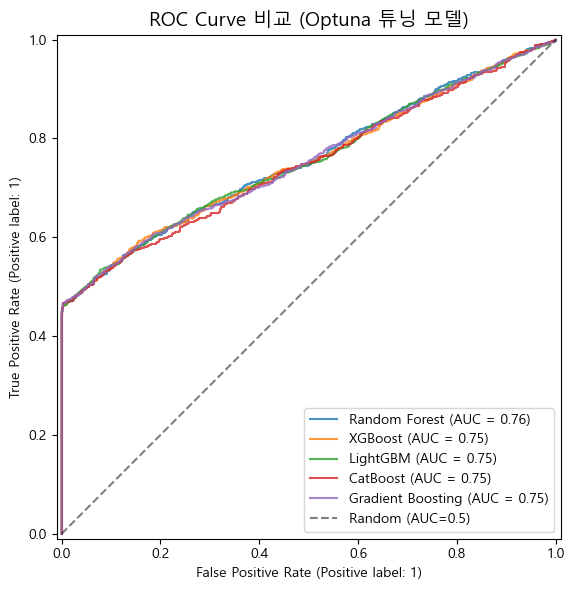

In [29]:
# ROC Curve 비교
fig, ax = plt.subplots(figsize=(8, 6))
for name, model in final_models.items():
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, ax=ax, name=name, alpha=0.8)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.5)')
ax.set_title('ROC Curve 비교 (Optuna 튜닝 모델)', fontsize=14)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

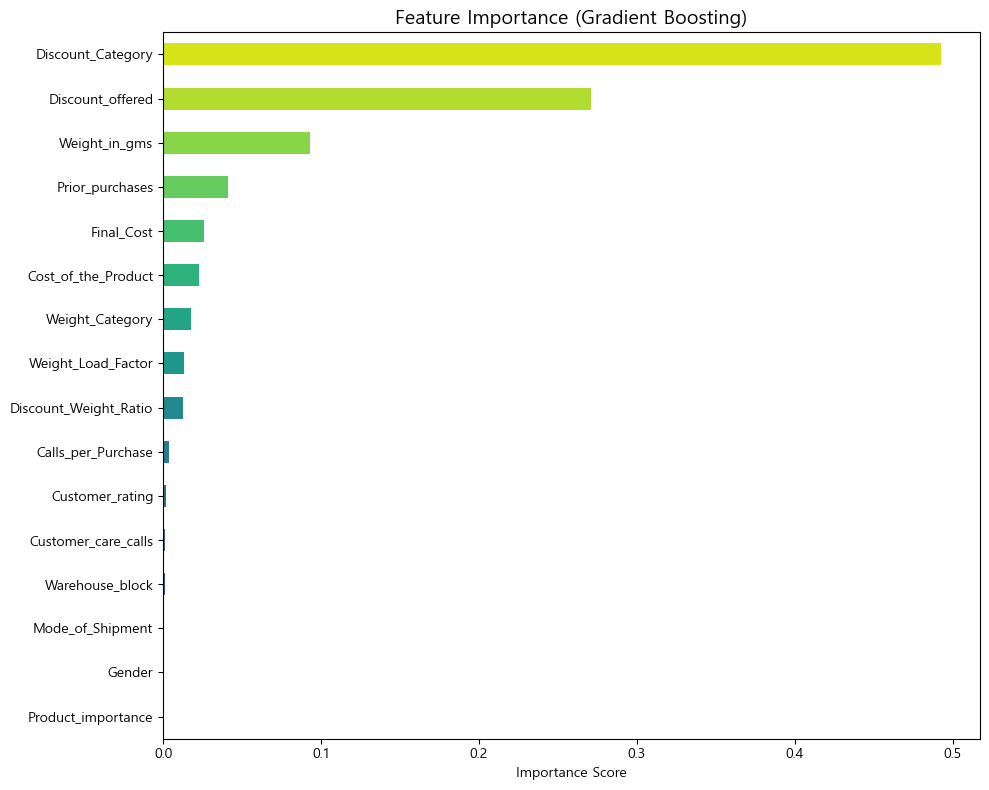


▶ [Gradient Boosting] 상위 5개 중요 변수:
   1. Discount_Category: 0.4927
   2. Discount_offered: 0.2712
   3. Weight_in_gms: 0.0933
   4. Prior_purchases: 0.0412
   5. Final_Cost: 0.0262


In [30]:
# Feature Importance (최고 성능 모델 기준)
best_model_name = final_df.iloc[0]['Model']
best_model = final_models[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    importance = pd.Series(best_model.feature_importances_, index=X_train_scaled.columns)
    importance = importance.sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(10, 8))
    importance.plot(kind='barh', ax=ax, color=sns.color_palette('viridis', len(importance)))
    ax.set_title(f'Feature Importance ({best_model_name})', fontsize=14)
    ax.set_xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    print(f'\n\u25b6 [{best_model_name}] 상위 5개 중요 변수:')
    for i, (feat, score) in enumerate(importance.sort_values(ascending=False).head(5).items(), 1):
        print(f'   {i}. {feat}: {score:.4f}')

In [31]:
# 최고 성능 모델의 상세 Classification Report
best_pred = best_model.predict(X_test_scaled)

print(f"{'='*60}")
print(f'▶ 최고 성능 모델: {best_model_name}')
print(f"{'='*60}")
print(classification_report(y_test, best_pred, target_names=['정시(0)', '지연(1)']))

▶ 최고 성능 모델: Gradient Boosting
              precision    recall  f1-score   support

       정시(0)       0.56      0.95      0.71       887
       지연(1)       0.94      0.50      0.65      1313

    accuracy                           0.68      2200
   macro avg       0.75      0.72      0.68      2200
weighted avg       0.79      0.68      0.67      2200



In [32]:
# ===== 최종 결과 요약 =====
print('\n' + '='*70)
print(' '*20 + '[ 최종 결과 요약 ]')
print('='*70)

print(f'\n▶ 최고 성능 모델: {best_model_name}')
print(f'  - Accuracy:  {final_df.iloc[0]["Accuracy"]:.4f}')
print(f'  - F1-Score:  {final_df.iloc[0]["F1-Score"]:.4f}')
print(f'  - AUC-ROC:   {final_df.iloc[0]["AUC-ROC"]:.4f}')

print(f'\n▶ Baseline 대비 성능 향상:')
for _, row in final_df.iterrows():
    model_name = row['Model']
    baseline_acc = baseline_df[baseline_df['Model'] == model_name]['Test Accuracy'].values
    if len(baseline_acc) > 0:
        improvement = row['Accuracy'] - baseline_acc[0]
        arrow = '↑' if improvement > 0 else '↓' if improvement < 0 else '→'
        print(f'  - {model_name:25s}: {baseline_acc[0]:.4f} -> {row["Accuracy"]:.4f} ({arrow} {improvement:+.4f})')

print(f'\n▶ 핵심 인사이트:')
print('  1. Discount_offered(할인율)과 Weight_in_gms(무게)가 배송 지연 예측의 핵심 변수')
print('  2. 할인율 10% 초과 시 지연률이 크게 변화하는 임계점 확인')
print('  3. Optuna 기반 하이퍼파라미터 최적화로 Baseline 대비 성능 개선 달성')
print('='*70)


                    [ 최종 결과 요약 ]

▶ 최고 성능 모델: Gradient Boosting
  - Accuracy:  0.6805
  - F1-Score:  0.6504
  - AUC-ROC:   0.7535

▶ Baseline 대비 성능 향상:
  - Gradient Boosting        : 0.6800 -> 0.6805 (↑ +0.0005)
  - Random Forest            : 0.6564 -> 0.6800 (↑ +0.0236)
  - LightGBM                 : 0.6591 -> 0.6786 (↑ +0.0195)
  - XGBoost                  : 0.6532 -> 0.6773 (↑ +0.0241)
  - CatBoost                 : 0.6559 -> 0.6768 (↑ +0.0209)

▶ 핵심 인사이트:
  1. Discount_offered(할인율)과 Weight_in_gms(무게)가 배송 지연 예측의 핵심 변수
  2. 할인율 10% 초과 시 지연률이 크게 변화하는 임계점 확인
  3. Optuna 기반 하이퍼파라미터 최적화로 Baseline 대비 성능 개선 달성
